In [17]:
import numpy as np
import os
import datetime
import os

import imageio # using as an alternative of imread as it is deprecated
from PIL import Image # using as an alternative of imread as it is deprecated

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [18]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [19]:
# mount google drive.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [20]:
#Extract Data
#!unzip '/gdrive/MyDrive/Project_data.zip' -d '/gdrive/MyDrive/Project_data'

In [21]:
train_doc = np.random.permutation(open('/content/gdrive/MyDrive/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/Project_data/Project_data/val.csv').readlines())



In [22]:
batch_size = 64 #experiment with the batch size

# Building a Conv3D model

# Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [23]:
from skimage.transform import resize

In [24]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(source_path)//batch_size # calculate the number of batches
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,18,84,84,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx):
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32) #cropping the (120X160) image to make (120X120)
                    else:
                        print("")
                        image = resize(image,(84,84)).astype(np.float32)
                    # Normalizing RGB image with mean subtraction
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size!=0):
            batch_data = np.zeros((len(t)%batch_size,18,84,84,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*(len(t)%batch_size))].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*(len(t)%batch_size))].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)
                    # Normalizing RGB image with mean subtraction
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*(len(t)%batch_size))].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [25]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/MyDrive/Project_data/Project_data/train'
val_path = '/content/gdrive/MyDrive/Project_data/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


# Model
Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [26]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout

from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.optimizers import Adam

In [27]:
#write your model here
Input_shape = (18, 84, 84, 3)

model3D = Sequential()
model3D.add(Conv3D(64, (3,3,3), padding='same', input_shape=(18,84,84,3)))
model3D.add(BatchNormalization())
model3D.add(Activation('elu'))
model3D.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model3D.add(Conv3D(128, (3,3,3), padding='same'))
model3D.add(BatchNormalization())
model3D.add(Activation('elu'))
model3D.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model3D.add(Conv3D(256, (3,3,3), padding='same'))
model3D.add(BatchNormalization())
model3D.add(Activation('elu'))
model3D.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model3D.add(Conv3D(256, (3,3,3), padding='same'))
model3D.add(BatchNormalization())
model3D.add(Activation('elu'))
model3D.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model3D.add(Flatten())
model3D.add(Dropout(0.5))
model3D.add(Dense(512, activation='elu'))
model3D.add(Dropout(0.5))
model3D.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [28]:
optimiser = optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model3D.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'],run_eagerly=True)
print (model3D.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 84, 84, 64)    5248      
                                                                 
 batch_normalization_4 (Bat  (None, 18, 84, 84, 64)    256       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 18, 84, 84, 64)    0         
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 9, 42, 84, 64)     0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 42, 84, 128)    221312    
                                                                 
 batch_normalization_5 (Bat  (None, 9, 42, 84, 128)   

Let us create the train_generator and the val_generator which will be used in .fit_generator.

In [29]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [30]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [31]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [32]:
history = model3D.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs,
                    verbose=1, callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/Project_data/train ; batch size = 64
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 4.3426 - categorical_accuracy: 0.3399Source path =  /content/gdrive/MyDrive/Project_data/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2023-12-0516_43_18.131123/model-00001-4.34255-0.33992-37.92296-0.29167.h5
11/11 [==============================] - 125s 12s/step - loss: 4.3426 - categorical_accuracy: 0.3399 - val_loss: 37.9230 - val_categorical_accuracy: 0.2917 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 2.7308 - categorical_accuracy: 0.4229 
Epoch 2: saving model to model_init_2023-12-0516_43_18.131123/model-00002-2.73082-0.42292-33.76855-0.30556.h5
11/11 [==============================] - 218s 22s/step - loss: 2.7308 - categorical_accuracy: 0.4229 - val_loss: 33.7685 - val_categorical_accuracy: 0.3056 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - E

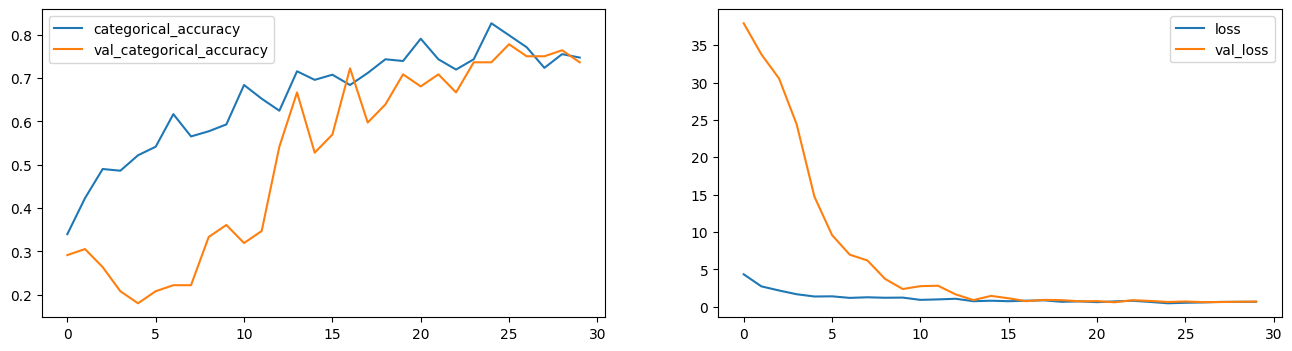

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

In [34]:
model3D.save("Conv3D_final.h5")

In [35]:
from google.colab import files
files.download("Conv3D_final.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Building a model with CNN and RNN

# Generator

In [ ]:
from skimage.transform import resize

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(source_path)//batch_size # calculate the number of batches
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,18,84,84,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx):
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32) #cropping the (120X160) image to make (120X120)
                    else:
                        print("")
                        image = resize(image,(84,84)).astype(np.float32)
                    # Normalizing RGB image with mean subtraction
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size!=0):
            batch_data = np.zeros((len(t)%batch_size,18,84,84,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*(len(t)%batch_size))].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*(len(t)%batch_size))].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)
                    # Normalizing RGB image with mean subtraction
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*(len(t)%batch_size))].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/MyDrive/Project_data/Project_data/train'
val_path = '/content/gdrive/MyDrive/Project_data/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Building the model

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout

from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.optimizers import Adam

In [ ]:
Input_shape = (18, 84, 84, 3)

model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'), input_shape = Input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'],run_eagerly=True)
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeD  (None, 18, 84, 84, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 18, 84, 84, 16)    64        
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, 18, 42, 42, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_13 (TimeD  (None, 18, 42, 42, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, 18, 42, 42, 32)   

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs,
                    verbose=1, callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/Project_data/train ; batch size = 64
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.6955 - categorical_accuracy: 0.2174  Source path =  /content/gdrive/MyDrive/Project_data/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2023-12-0504_01_00.376987/model-00001-1.69553-0.21739-1.75243-0.19444.h5
11/11 [==============================] - 1340s 133s/step - loss: 1.6955 - categorical_accuracy: 0.2174 - val_loss: 1.7524 - val_categorical_accuracy: 0.1944 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.4349 - categorical_accuracy: 0.3597 
Epoch 2: saving model to model_init_2023-12-0504_01_00.376987/model-00002-1.43491-0.35968-1.93579-0.22222.h5
11/11 [==============================] - 628s 62s/step - loss: 1.4349 - categorical_accuracy: 0.3597 - val_loss: 1.9358 - val_categorical_accuracy: 0.2222 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - E

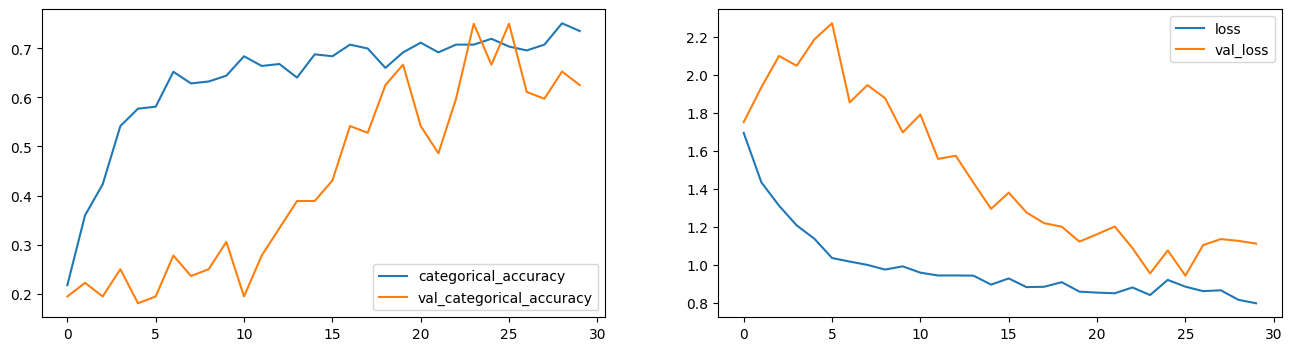

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

### Conclusion:
The best model out of all the experiments conducted is experiment number 5 wherein we trained the model with: image frame 84X84, alternate images fed to the model, momentum of 0.9 in SGD optimizer. As can be seen, the accuracies are converging within a 5% range. There is no sign of the model under or over-fitting.
Experiments were also conducted using a CNN and RNN model. Apart from taking considerable time to train, the models also showed no sign of improved accuracy. The model always seems to either under-fit or over-fit.


In [ ]:
model.save("CNN_RNN.h5")

In [ ]:
files.download("CNN_RNN.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>